In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import torch

from archetypal import UmiTemplateLibrary
from ladybug.epw import EPW 
from lightning.pytorch import Trainer

from ml.data import BuildingDataModule
from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from umi.ubem import UBEM

Couldn't import dot_parser, loading of dot files will not be possible.


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package energy-pandas is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.8.17
[Taichi] Starting on arch=cuda


In [2]:
bucket = "ml-for-bem"
remote_experiment = "full_climate_zone/v5"
local_data_dir = "data/lightning"

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v1"
resource = "model-with-transform-configs.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
gdf = gpd.read_file(Path("data") / "gis" / "Florianopolis_Baseline_sam.zip")

# dict to store key fields for known gis files
id_cols = {
    "florianpolis": {
        "height_col": "HEIGHT",
        "id_col": "OBJECTID",
        "template_name_col": "template_name",
        "wwr_col": "wwr",
    }
}

epw_fp = (
    Path("data")
    / "epws"
    / "global_epws_indexed"
    / "cityidx_0305_MNG_--ULAANBATAAR.442920_IWEC Data.epw"
    # / "cityidx_0007_USA_IL-Chicago Midway.725340_TMY--14819.epw"
)

epw = EPW(epw_fp)
template_lib = UmiTemplateLibrary.open(
    Path("data") / "template_libs" / "BostonTemplateLibrary.json"
)

# Insert dummy template names
gdf[id_cols["florianpolis"]["template_name_col"]] = np.random.choice(
    [t.Name for t in template_lib.BuildingTemplates], size=gdf.shape[0]
)
# insert dummy wwrs
gdf[id_cols["florianpolis"]["wwr_col"]] = 0.4

umi_test = UBEM(
    gdf=gdf,
    **id_cols["florianpolis"],
    epw=epw,
    template_lib=template_lib,
    shoebox_width=3,
    floor_to_floor_height=4,
    perim_offset=4,
)

DEBUG:UMI:Fetching BuildingTemplate vector data from B_Off_0
DEBUG:UMI:Found facade with r_value 2.06 and tmass bin 1
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.25 and tmass bin 0
DEBUG:UMI:Fetching BuildingTemplate vector data from B_Ret_0
DEBUG:UMI:Found facade with r_value 2.06 and tmass bin 1
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.25 and tmass bin 0
DEBUG:UMI:Fetching BuildingTemplate vector data from B_Res_0_Masonry
DEBUG:UMI:Found facade with r_value 2.06 and tmass bin 1
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.3 and tmass bin 1
DEBUG:UMI:Fetching BuildingTemplate vector data from B_Res_0_WoodFrame
DEBUG:UMI:Found facade with r_value 2.84 and tmass bin 3
DEBUG:UMI:Found slab with r_value 0.71
DEBUG:UMI:Found roof with r_value 3.3 and tmass bin 1
INFO:Radiation Analysis:Beginning sky matrix extraction...
INFO:Radiation Analysis:Building Count: 93
INFO:Radiation Analysis:Approximat

In [11]:

features, schedules, climate = umi_test.prepare_for_surrogate()
features["WindowShgc"] = 0.8

torch.set_float32_matmul_precision("medium")
shoebox_predictions, monthly_predictions, annual_predictions = predict_ubem(
        trainer=trainer,
        surrogate=surrogate,
        features=features,
        schedules=schedules,
        climate=climate,
        batch_size=32,
    )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 24.46it/s]


array([[<Axes: title={'center': 'Cooling'}>,
        <Axes: title={'center': 'Heating'}>]], dtype=object)

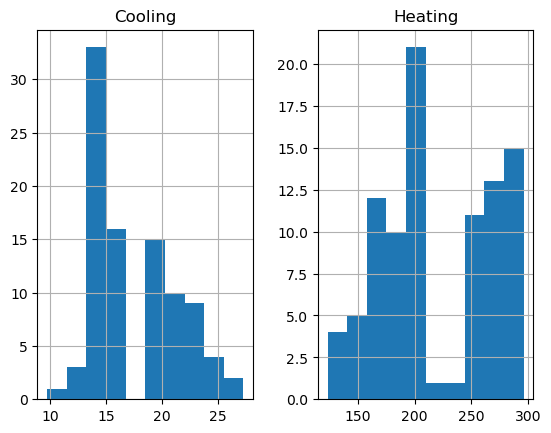

In [12]:
annual_predictions.hist()

In [16]:
pd.read_csv("data/SeedValidation/seed_ulaanbataar_cooling.csv")[[str(i) for i in range(8760) ]]

Index(['Building Id', 'Building Name', 'Metric', 'Units', 'Resolution', '1',
       '2', '3', '4', '5',
       ...
       '8751', '8752', '8753', '8754', '8755', '8756', '8757', '8758', '8759',
       '8760'],
      dtype='object', length=8765)